## Introduction

### Problem Statement

The file askscience_data.csv is a collection of posts from the subreddit r/askscience. The task comes with two parts:

- Determine the attributes of a successful post on r/askscience

- Build a model that can predict the score of a post on r/askscience given at least the title and body of the post (There is no need to limit it to just the title and body, but you must explain why you chose the features you did).

### Approach

In order to solve this problem I will first perform an Exploratory Data Analysis or EDA.  This will both answer the first part of the task, while also giving insight into the feature engineering necessary to complete the second part.

## EDA

In [1]:
#import packages
import numpy as np
import pandas as pd
import math
from statistics import mean, median
import datetime

from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load and view data
reddit = pd.read_csv("/Users/jrgor/Documents/takehome-joseph/askscience_data.csv")
reddit.drop(columns = "Unnamed: 0",inplace=True)
reddit

,title,body,tag,datetime,author,score,upvote_ratio,url
0,Post viral cough: why does it get worse after ...,Tl;dr: why is your cough during an upper respi...,Human Body,2022-12-09 02:52:07,CarboniferousCreek,1343.0,0.93,https://www.reddit.com/r/askscience/comments/z...
1,Can an x-ray of an adult show chronic malnouri...,If a person was chronically undernourished thr...,Human Body,2022-12-08 18:28:51,Foxs-In-A-Trenchcoat,426.0,0.91,https://www.reddit.com/r/askscience/comments/z...
2,[META] Bots and AI tools on r/askscience,\n\nOver the past few days we have seen a sur...,META,2022-12-08 09:04:25,AskScienceModerator,2218.0,0.92,https://www.reddit.com/r/askscience/comments/z...
3,Can you predictably manipulate a magnetic gas?,Does there exist a gas that changes in respons...,Physics,2022-12-08 20:01:53,hufsa7,48.0,0.83,https://www.reddit.com/r/askscience/comments/z...
4,Are there cells in humans (or other mammals) t...,NaN,Medicine,2022-12-09 01:11:34,Velym,14.0,0.89,https://www.reddit.com/r/askscience/comments/z...
...,...,...,...,...,...,...,...,...
4200,I heard some electron microscopes use gallium....,NaN,Engineering,2022-01-12 17:14:35,Emma_Dale20,6.0,0.70,https://www.reddit.com/r/askscience/comments/s...
4201,is the spread of COVID typical for a respirato...,i understand that there's no respiratory virus...,COVID-19,2022-01-12 09:39:55,aggasalk,27.0,0.74,https://www.reddit.com/r/askscience/comments/s...
4202,What is the technical difference between Cheek...,What are the technical difference(s) between t...,COVID-19,2022-01-12 14:47:28,h110hawk,3.0,0.67,https://www.reddit.com/r/askscience/comments/s...
4203,What starts the coagulation cascade during blo...,I understand that stasis of blood increases th...,Human Body,2022-01-12 14:20:26,joegoldbergg,5.0,0.78,https://www.reddit.com/r/askscience/comments/s...


Looking at the score data to start we can see that it is very right skewed

Text(0.5, 1.0, 'Score Histogram')

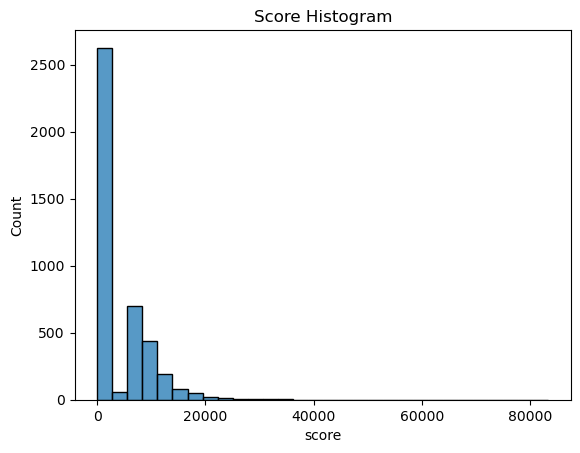

In [3]:
sns.histplot(reddit["score"],bins=30).set_title("Score Histogram")

In [4]:
reddit["score"].describe()

count     4205.000000
mean      3730.471106
std       5577.606541
min          0.000000
25%          4.000000
50%         35.000000
75%       7472.000000
max      83382.000000
Name: score, dtype: float64

In [5]:
#just under 1/8th of the scores are 0
#these must be converted to 1 in order to do a log transformation
print(sum(reddit["score"]<=0))
reddit["score_0to1"] = [1 if x==0 else x for x in reddit["score"]]
reddit["log_score"]= [math.log(x) for x in reddit["score_0to1"]]

508


Text(0.5, 1.0, 'Log Score Histogram')

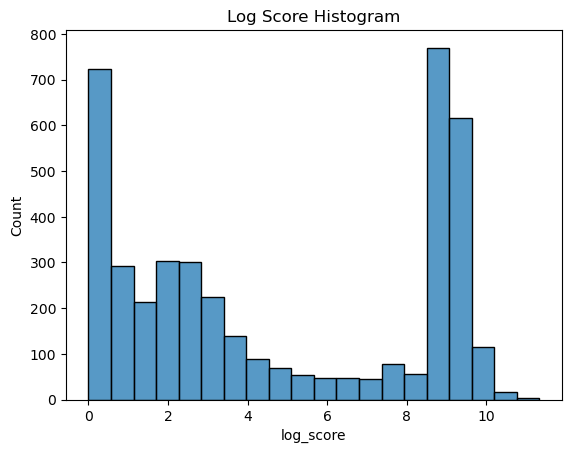

In [6]:
sns.histplot(reddit["log_score"],bins=20).set_title("Log Score Histogram")

Text(0.5, 1.0, 'Log Score Histogram (0 values removed)')

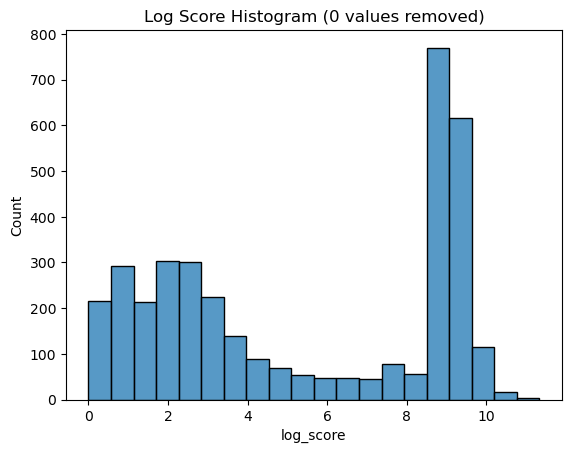

In [7]:
#Now without zeros
sns.histplot(reddit["log_score"][reddit["score"]>0],bins=20).set_title("Log Score Histogram (0 values removed)")

We can see there is an interesting bimodality in the score data on the low and high ends.  We can potentially think of this as the difference between standard posts and those that make it to the front page (go viral)

Next we can look at some of the metadata. We can extract metadata  in addition to the content from the title and body columns to analyze.

In [8]:
reddit["title_length"] = [len(x) for x in reddit["title"]]
reddit["body_length"] = [len(x) if pd.notna(x) else 0 for x in reddit["body"]]

In [9]:
reddit["body_length_0to1"] = [1 if x==0 else x for x in reddit["body_length"]]
reddit["log_body_length"] = [math.log(x) for x in reddit["body_length_0to1"]]

The title_length data is also right skewed but unlike score and body_length, title is bound and must be greater than 0 but less than 300 (some subreddits have further rules as well)

Text(0.5, 1.0, 'Title Length Histogram')

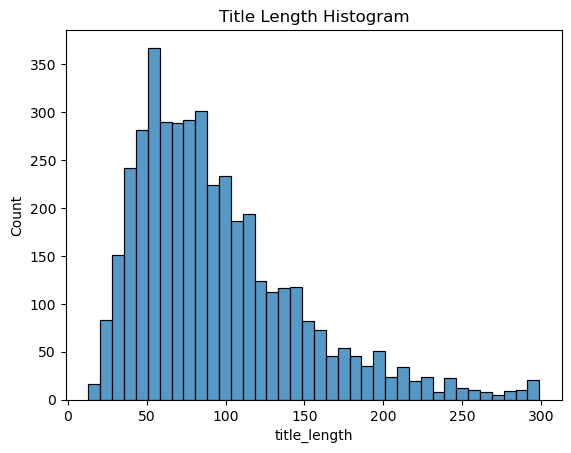

In [10]:
sns.histplot(reddit["title_length"]).set_title("Title Length Histogram")

In [11]:
reddit["title_length"].describe()

count    4205.000000
mean       95.023306
std        52.135180
min        13.000000
25%        57.000000
50%        83.000000
75%       119.000000
max       299.000000
Name: title_length, dtype: float64

We can see that there is some positive correlation between score and title length

In [12]:
#Quartile comparison
print("Mean score of first title length quartile:")
print(mean(reddit["score"][reddit["title_length"]<np.percentile(reddit["title_length"],25)]))
print("Mean score of second title length quartile:")
print(mean(reddit["score"][(reddit["title_length"]>=np.percentile(reddit["title_length"],25)) & (reddit["title_length"]<np.percentile(reddit["title_length"],50))]))
print("Mean score of third title length quartile:")
print(mean(reddit["score"][(reddit["title_length"]>=np.percentile(reddit["title_length"],50)) & (reddit["title_length"]<np.percentile(reddit["title_length"],75))]))
print("Mean score of fourth title length quartile:")
print(mean(reddit["score"][reddit["title_length"]>=np.percentile(reddit["title_length"],75)]))

Mean score of first title length quartile:
2216.0096525096524
Mean score of second title length quartile:
2763.76499032882
Mean score of third title length quartile:
4243.438661710037
Mean score of fourth title length quartile:
5634.723323890463


Text(0.5, 1.0, 'Title Length-Score Scatter Plot (w/ Lowess line)')

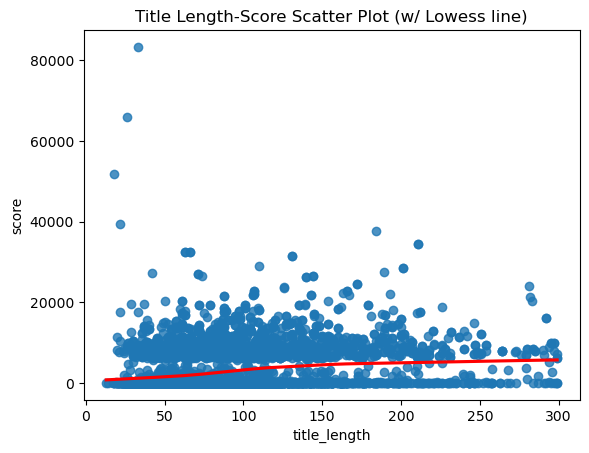

In [13]:
sns.regplot(x = reddit["title_length"],y = reddit["score"],lowess=True,line_kws = {'color':'red'}).set_title("Title Length-Score Scatter Plot (w/ Lowess line)")

Text(0.5, 1.0, 'Title Length-Log Score Scatter Plot')

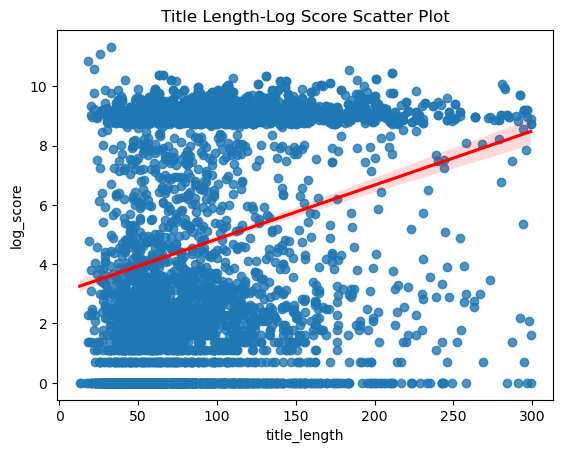

In [14]:
sns.regplot(x = reddit["title_length"],y = reddit["log_score"],line_kws = {'color':'red'}).set_title("Title Length-Log Score Scatter Plot")

We can see however, that the data is noisy and the lowess line suggest the correlation may not be linear

Text(0.5, 1.0, 'Title Length-Log Score Scatter Plot (w/ Lowess Line)')

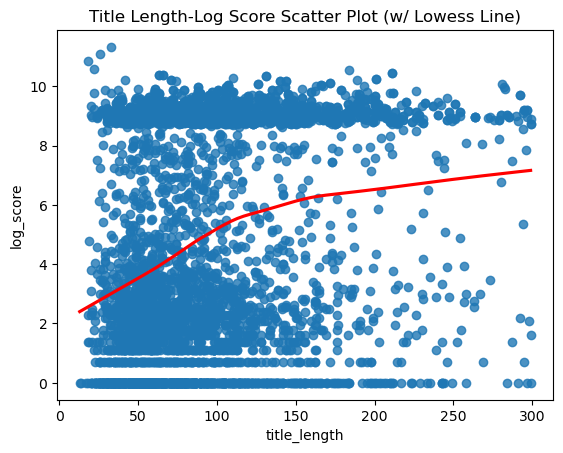

In [15]:
sns.regplot(x = reddit["title_length"],y = reddit["log_score"],lowess=True,line_kws = {'color':'red'}).set_title("Title Length-Log Score Scatter Plot (w/ Lowess Line)")

Body Length (similar to score) has no commonly hit upper bound (the actual limit is 40000 characters) and is very right skewed

Text(0.5, 1.0, 'Body Length Histogram')

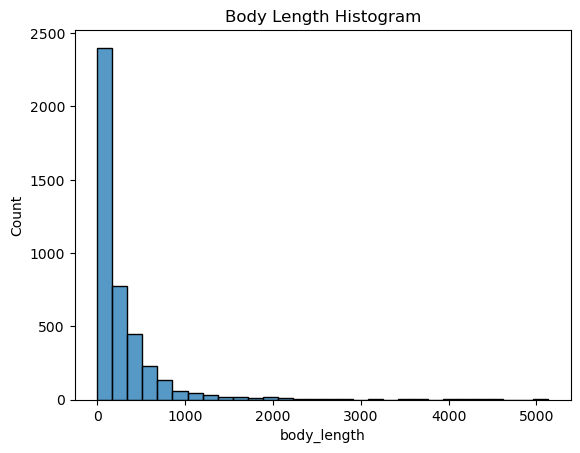

In [16]:
sns.histplot(reddit["body_length"],bins=30).set_title("Body Length Histogram")

Note that approximately 1/3rd of all body texts are empty

In [17]:
print(sum(reddit["body_length"]==0))

1713


Text(0.5, 1.0, 'Non-Zero Body Length Histogram')

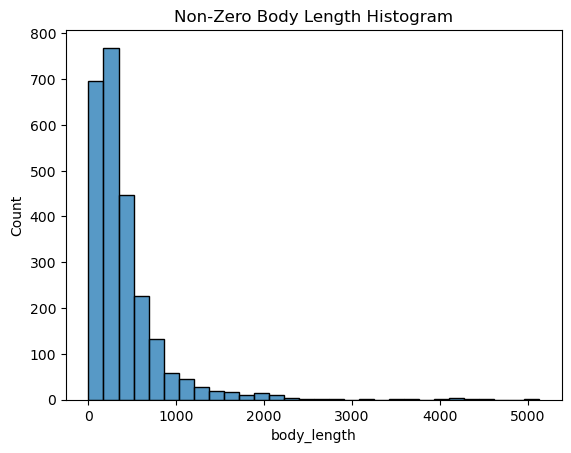

In [18]:
sns.histplot(reddit["body_length"][reddit["body_length"]>0],bins=30).set_title("Non-Zero Body Length Histogram")

Text(0.5, 1.0, 'Log of Non-Zero Body Length Histogram')

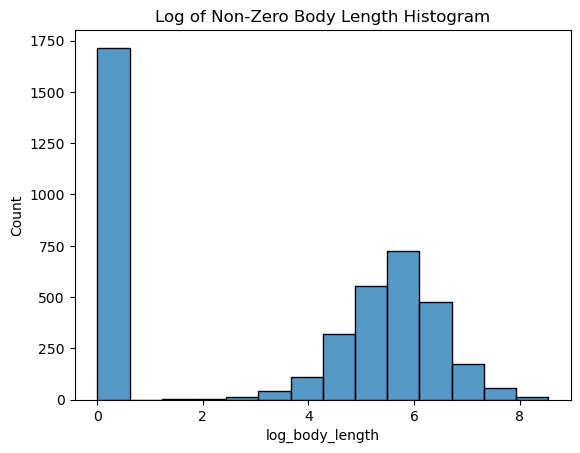

In [19]:
#ignoring the large number of 0 values the rest of the data looks unimodal
sns.histplot(reddit["log_body_length"]).set_title("Log of Non-Zero Body Length Histogram")

It may look as though there is a negative correlation between score and body length

Text(0.5, 1.0, 'Body Length-Score Scatterplot')

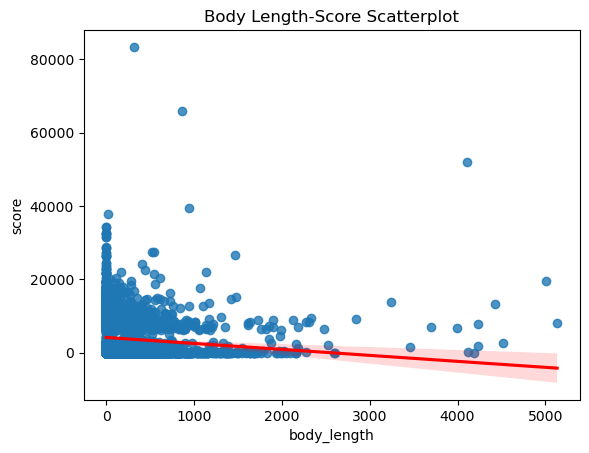

In [20]:
sns.regplot(x = reddit["body_length"],y = reddit["score"],line_kws = {'color':'red'}).set_title("Body Length-Score Scatterplot")

Text(0.5, 1.0, 'Body Length-Log Score Scatterplot')

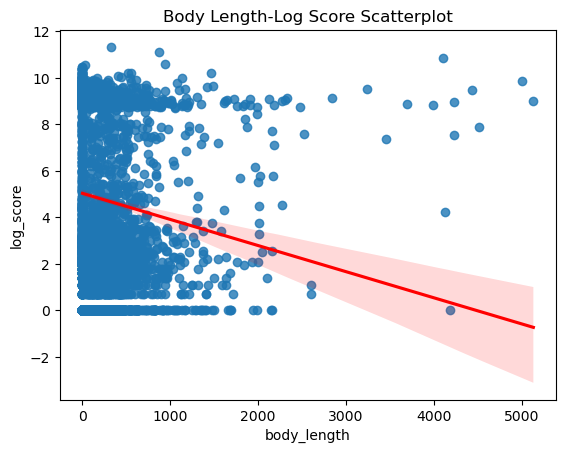

In [21]:
sns.regplot(x = reddit["body_length"],y = reddit["log_score"],line_kws = {'color':'red'}).set_title("Body Length-Log Score Scatterplot")

However the lowess line indicates the relationship may be highly nonlinear and not monotonically negative

Text(0.5, 1.0, 'Body Length-Log Score Scatterplot (w/ Lowess Line)')

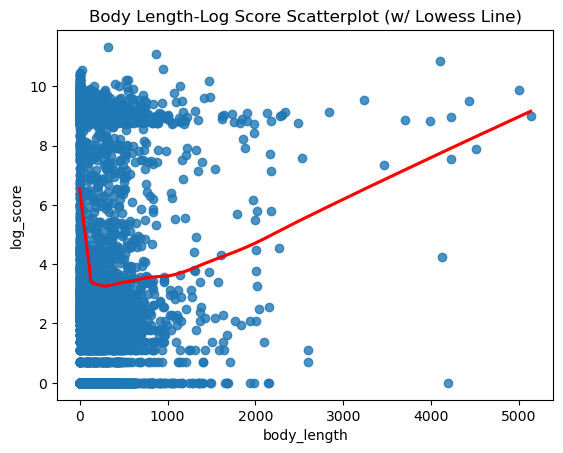

In [22]:
sns.regplot(x = reddit["body_length"],y = reddit["log_score"],lowess=True, line_kws = {'color':'red'}).set_title("Body Length-Log Score Scatterplot (w/ Lowess Line)")

Performing a log transformation on body length and removing zero values makes the percieved negative linear relationship completely disappear

Text(0.5, 1.0, 'Log Body Length-Log Score Scatterplot')

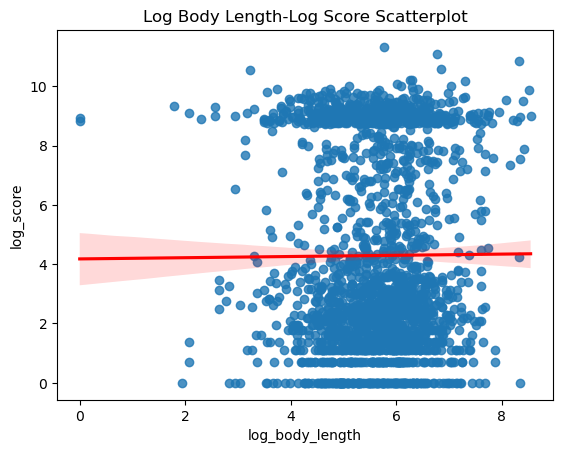

In [23]:
sns.regplot(x = reddit["log_body_length"][((reddit["body_length"]!=0) & (reddit["score"]!=0))],
            y = reddit["log_score"][((reddit["body_length"]!=0) & (reddit["score"]!=0))],
            line_kws = {'color':'red'}).set_title("Log Body Length-Log Score Scatterplot")

This indicates that it may be advantageous to create a one-hot variable indicating whether a body length is empty

Now we can look at authors.

We can see that there are two authors that account for more posts, AskScienceModerator and DELETED (which indicates the original posting account was deleted)

In [24]:
reddit["author"].value_counts()

author
DELETED                246
AskScienceModerator     47
inquilinekea            12
Toorelad                 6
Gargatua13013            6
                      ... 
Weird-Vagina-Beard       1
FilthySJW                1
TrillCozbey              1
BobbyTables829           1
joegoldbergg             1
Name: count, Length: 3314, dtype: int64

In [25]:
reddit_groupby_author = reddit.groupby("author")["score"].agg([mean,median]).reset_index()

print("Whole sample mean: {}   Whole sample median: {}".format(mean(reddit["score"]),median(reddit["score"])))
reddit_groupby_author[(reddit_groupby_author["author"]=="AskScienceModerator")|(reddit_groupby_author["author"]=="DELETED")]


Whole sample mean: 3730.471105826397   Whole sample median: 35.0


,author,mean,median
154,AskScienceModerator,8948.617021,7230.0
404,DELETED,4185.504065,19.0


AskScienceModerator has a notable higher value while DELETED does not

Anova shows there is significance for AskScienceModerator but not DELETED however AskScienceModerator only represents 1% of the data

That being said it may be something useful to split on in a random forest or boosting model

In [26]:
f_oneway(reddit["score"][reddit["author"]=="AskScienceModerator"],
        reddit["score"][reddit["author"]!="AskScienceModerator"])

F_onewayResult(statistic=42.00798654087142, pvalue=1.0138941946796534e-10)

In [27]:
f_oneway(reddit["score"][reddit["author"]=="DELETED"],
        reddit["score"][reddit["author"]!="DELETED"])

F_onewayResult(statistic=1.7393297906862033, pvalue=0.18729562102794597)

Looking at tags we can see that there are some that perform better than others

In [28]:
reddit["tag"] = ['Empty' if pd.isna(x) else x for x in reddit["tag"]]
reddit_groupby_tag = reddit.groupby("tag")["score"].agg(['mean','median','size'])
reddit_groupby_tag.sort_values("size",ascending=False)

,mean,median,size
tag,,,
Biology,4066.599448,95.0,724
Physics,3334.267516,24.5,628
Human Body,4356.281659,1268.0,458
Medicine,3191.157738,46.0,336
Earth Sciences,4721.377358,369.0,318
Astronomy,3934.937500,64.5,272
Chemistry,2671.558952,10.0,229
COVID-19,4457.211009,34.5,218
Empty,489.850515,1.0,194


In [29]:
#top 10 scoring tags
reddit_groupby_tag.sort_values("mean",ascending=False)[0:10]

,mean,median,size
tag,,,
Meta,39288.000000,39288.0,1
First image of a black hole,13233.000000,13233.0,1
Ecology,9213.500000,9213.5,2
Anthropology,6975.869565,6275.0,23
Dog Cognition AMA,6880.000000,6880.0,1
CERN AMA,6776.000000,6776.0,1
Earth Sciences and Biology,6567.500000,6567.5,2
Computing,6095.689655,6521.5,58
Linguistics,5978.529412,6572.0,34


In [30]:
#revising rare tags before assessing their value
reddit["tag_revised"] = ['Other' if x in ['Ecology','Earth Sciences and Biology','Interdisciplinary','META','Meta','Materials Science','First image of a black hole','Dog Cognition AMA','CERN AMA','  Linguistics','Political Science','Food'] else x for x in reddit["tag"]]
reddit["tag_revised"].value_counts()

tag_revised
Biology           724
Physics           628
Human Body        458
Medicine          336
Earth Sciences    318
Astronomy         272
Chemistry         229
COVID-19          218
Empty             194
Engineering       190
Planetary Sci.    111
Neuroscience      107
Mathematics       102
Psychology         90
Computing          58
Paleontology       47
Linguistics        34
Anthropology       23
Social Science     20
Other              17
Archaeology        15
Economics          14
Name: count, dtype: int64

We can see that tags do provide useful information though not all tags are too distinct from mean

In [31]:
formula = "log_score ~ tag_revised"
lm_tag = ols(formula, reddit).fit()
lm_tag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_score   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     15.97
Date:                Sat, 06 Apr 2024   Prob (F-statistic):           5.35e-56
Time:                        11:38:30   Log-Likelihood:                -11355.
No. Observations:                4205   AIC:                         2.275e+04
Df Residuals:                    4183   BIC:                         2.289e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         6.8281      0.753      9.067      0.000       5.352       8.304
tag_revised[T.Archaeology]       -2.5959      1.199     -2.166      0.030      -4.946      -0.246
tag_revised[T.Astronomy]         -1.8192      0.784     -2.320      0.020      -3.357      -0.282
tag_revised[T.Biology]           -1.6379      0.765     -2.141      0.032      -3.138      -0.138
tag_revised[T.COVID-19]          -2.0127      0.792     -2.542      0.011      -3.565      -0.460
tag_revised[T.Chemistry]         -2.8926      0.790     -3.662      0.000      -4.441      -1.344
tag_revised[T.Computing]         -0.8640      0.890     -0.971      0.332      -2.609       0.881
tag_revised[T.Earth Sciences]    -1.4034      0.780     -1.800      0.072      -2.932       0.125
tag_revised[T.Economics]         -5.5396      1.224     -4.525      0.000      -7.940      -3.139
tag_revised[T.Empty]             -5.7200      0.796     -7.182      0.000      -7.281      -4.159
tag_revised[T.Engineering]       -1.3364      0.797     -1.676      0.094      -2.900       0.227
tag_revised[T.Human Body]        -1.2348      0.772     -1.600      0.110      -2.748       0.278
tag_revised[T.Linguistics]       -0.4458      0.975     -0.457      0.648      -2.357       1.466
tag_revised[T.Mathematics]       -3.2634      0.834     -3.915      0.000      -4.898      -1.629
tag_revised[T.Medicine]          -2.0445      0.778     -2.626      0.009      -3.571      -0.518
tag_revised[T.Neuroscience]      -2.5887      0.830     -3.119      0.002      -4.216      -0.961
tag_revised[T.Other]             -1.3267      1.155     -1.148      0.251      -3.591       0.938
tag_revised[T.Paleontology]      -1.5887      0.919     -1.729      0.084      -3.391       0.213
tag_revised[T.Physics]           -2.4457      0.767     -3.190      0.001      -3.949      -0.943
tag_revised[T.Planetary Sci.]    -1.1889      0.827     -1.437      0.151      -2.811       0.433
tag_revised[T.Psychology]        -2.7092      0.844     -3.211      0.001      -4.364      -1.055
tag_revised[T.Social Science]    -3.9194      1.104     -3.550      0.000      -6.084      -1.755
==============================================================================
Omnibus:                    23405.121   Durbin-Watson:                   0.402
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              421.361
Skew:                           0.044   Prob(JB):                     3.18e-92
Kurtosis:                       1.452   Cond. No.                         67.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
anova_lm(lm_tag)

,df,sum_sq,mean_sq,F,PR(>F)
tag_revised,21.0,4375.359972,208.350475,15.973723,5.349052e-56
Residual,4183.0,54560.230766,13.043326,NaN,NaN


Now lets create some temporal variables. We can extract hour, day of week, and month from the timestamp

In [33]:
reddit["datetime_revised"] = [datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S") for x in reddit["datetime"]]
reddit["hour"] = [x.hour for x in reddit["datetime_revised"]]
reddit["dayofweek"] = [x.dayofweek for x in reddit["datetime_revised"]]
reddit["month"] = [x.month for x in reddit["datetime_revised"]]

In [34]:
#for the sake of brevity, I am excluding the non-zero groupby charts as they do not show a major change relative to 
#those that include zero
reddit_groupby_hour = reddit.groupby("hour")["score"].agg(["mean","median","size"])
reddit_groupby_hour

,mean,median,size
hour,,,
0,3549.743590,57.0,78
1,3428.269231,19.0,104
2,3503.759124,59.0,137
3,5035.000000,5121.0,169
4,5242.510460,6257.0,239
5,5059.663866,6156.5,238
6,5295.291971,3777.5,274
7,4128.642140,289.0,299
8,4902.809028,797.5,288


There is both a posting peak and a scoring peak between hours 3 and 8

Text(0.5, 1.0, 'Hour Barplot')

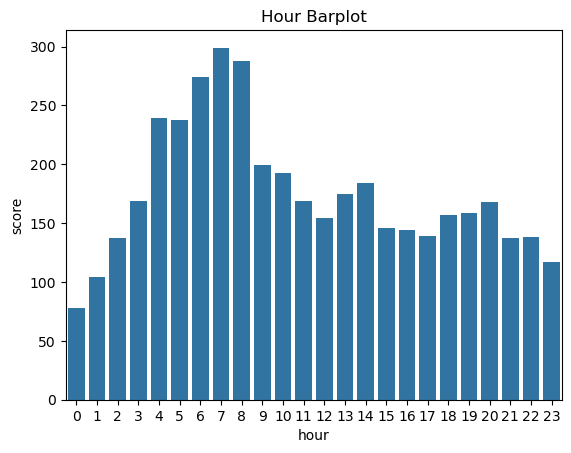

In [35]:
sns.barplot(data=reddit.loc[:,["score","hour"]], x="hour",y="score",errorbar=None,estimator="size").set_title("Hour Barplot")

Text(0.5, 1.0, 'Score by Hour Barplot')

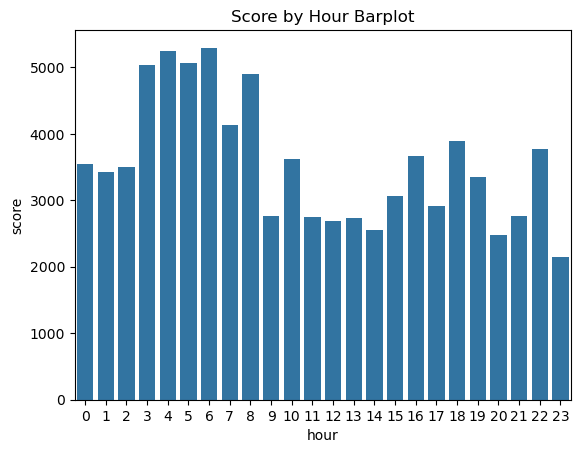

In [36]:
sns.barplot(data=reddit.loc[:,["score","hour"]], x="hour",y="score",errorbar=None).set_title("Score by Hour Barplot")

Looking at day of week we can see that there is not that much of a difference between the days (though there may still be information to be gained from this variable)

In [37]:
reddit_groupby_dow = reddit.groupby("dayofweek")["score"].agg(["mean","median","size"])
reddit_groupby_dow

,mean,median,size
dayofweek,,,
0,3762.496764,48.0,618
1,4019.334507,49.5,568
2,3640.948485,27.0,660
3,3485.456343,28.0,607
4,4022.293413,78.0,501
5,3259.768190,20.0,591
6,3966.721212,42.0,660


Month however shows fairly large differences especially for months 4 through 9 (of 2022)

In [38]:
reddit_groupby_month = reddit.groupby("month")["score"].agg(["mean","median","size"])
reddit_groupby_month

,mean,median,size
month,,,
1,2603.573013,20.0,541
2,2032.085404,12.0,644
3,4205.547264,36.5,402
4,5433.477876,6577.0,226
5,6103.646154,6884.0,195
6,6348.399015,7040.0,203
7,5838.407240,6550.0,221
8,5973.891213,6996.0,239
9,6633.308108,7163.0,185


Now looking at upvote ratio, we can see that it may be the strongest predictor of score

Text(0.5, 1.0, 'Upvote Ratio Histogram')

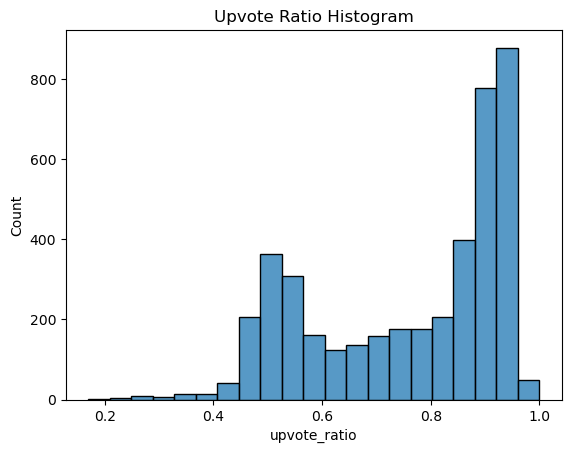

In [39]:
sns.histplot(reddit["upvote_ratio"]).set_title("Upvote Ratio Histogram")

Text(0.5, 1.0, 'Upvote Ratio-Score Scatterplot')

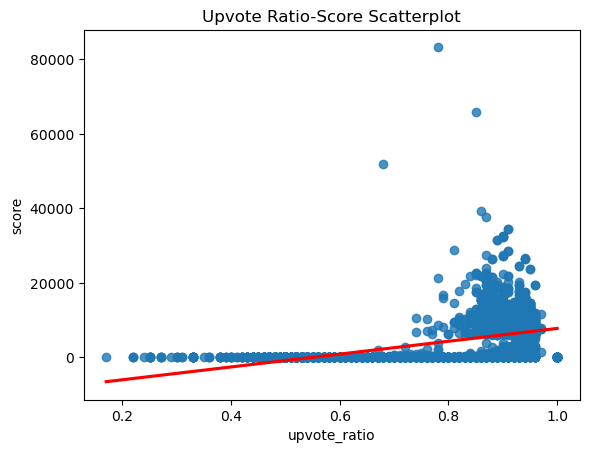

In [40]:
sns.regplot(data=reddit,x="upvote_ratio",y="score",line_kws = {'color':'red'}).set_title("Upvote Ratio-Score Scatterplot")

Text(0.5, 1.0, 'Upvote Ratio-Log Score Scatterplot')

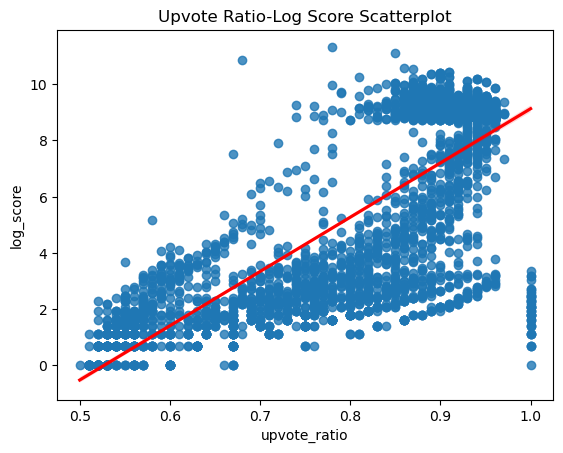

In [41]:
#we remove zero scores in order to make the graph look cleaner
sns.regplot(x=reddit["upvote_ratio"][reddit["score"]!=0],y=reddit["log_score"][reddit["score"]!=0],line_kws = {'color':'red'}).set_title("Upvote Ratio-Log Score Scatterplot")

The relationship may not however be linear.  The scatterplot looks potentially more quadratic in nature

Text(0.5, 1.0, 'Upvote Ratio-Log Score Scatterplot (w/ Lowess Line)')

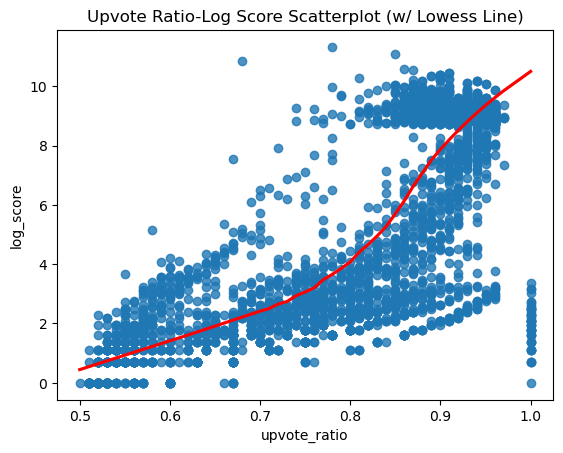

In [42]:
#the lowess line validates this suspicion
sns.regplot(x=reddit["upvote_ratio"][reddit["score"]!=0],y=reddit["log_score"][reddit["score"]!=0],lowess=True,line_kws = {'color':'red'}).set_title("Upvote Ratio-Log Score Scatterplot (w/ Lowess Line)")

Using a linear model and ANOVA to validate EDA suspicions (Though it is worth mentioning that this is just a check and is limited because using Linear Regression and ANOVA rely on assumptions around normality that are unlikely to be met in the dataset)

In [43]:
formula = "log_score ~ upvote_ratio + C(hour) + log_body_length + title_length + C(tag_revised) + C(dayofweek) + C(month)"
lm_basic = ols(formula, reddit).fit()

In [44]:
lm_basic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_score   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     236.6
Date:                Sat, 06 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:38:32   Log-Likelihood:                -8283.1
No. Observations:                4205   AIC:                         1.670e+04
Df Residuals:                    4140   BIC:                         1.711e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -8.6415      0.461    -18.760      0.000      -9.545      -7.738
C(hour)[T.1]                         0.3093      0.264      1.174      0.241      -0.207       0.826
C(hour)[T.2]                         0.3565      0.249      1.431      0.152      -0.132       0.845
C(hour)[T.3]                         0.7577      0.241      3.147      0.002       0.286       1.230
C(hour)[T.4]                         0.9527      0.229      4.158      0.000       0.504       1.402
C(hour)[T.5]                         0.8795      0.230      3.830      0.000       0.429       1.330
C(hour)[T.6]                         1.1016      0.226      4.881      0.000       0.659       1.544
C(hour)[T.7]                         0.7705      0.224      3.446      0.001       0.332       1.209
C(hour)[T.8]                         0.8605      0.225      3.832      0.000       0.420       1.301
C(hour)[T.9]                         0.2838      0.235      1.207      0.227      -0.177       0.745
C(hour)[T.10]                        0.3824      0.236      1.619      0.106      -0.081       0.846
C(hour)[T.11]                        0.1968      0.241      0.817      0.414      -0.276       0.669
C(hour)[T.12]                        0.2177      0.245      0.890      0.374      -0.262       0.697
C(hour)[T.13]                        0.1569      0.239      0.656      0.512      -0.312       0.626
C(hour)[T.14]                       -0.0751      0.238     -0.316      0.752      -0.541       0.391
C(hour)[T.15]                       -0.0316      0.246     -0.128      0.898      -0.515       0.451
C(hour)[T.16]                        0.3489      0.247      1.412      0.158      -0.135       0.833
C(hour)[T.17]                        0.2318      0.249      0.932      0.351      -0.256       0.719
C(hour)[T.18]                        0.0883      0.244      0.363      0.717      -0.389       0.566
C(hour)[T.19]                        0.1613      0.243      0.664      0.507      -0.315       0.638
C(hour)[T.20]                       -0.0164      0.241     -0.068      0.946      -0.489       0.456
C(hour)[T.21]                        0.1032      0.249      0.414      0.679      -0.386       0.592
C(hour)[T.22]                        0.0020      0.249      0.008      0.993      -0.485       0.490
C(hour)[T.23]                       -0.0168      0.257     -0.065      0.948      -0.520       0.487
C(tag_revised)[T.Archaeology]       -0.6768      0.584     -1.159      0.246      -1.822       0.468
C(tag_revised)[T.Astronomy]         -0.6269      0.382     -1.640      0.101      -1.376       0.123
C(tag_revised)[T.Biology]           -0.7345      0.373     -1.970      0.049      -1.466      -0.004
C(tag_revised)[T.COVID-19]           0.1099      0.38

In [45]:
anova_lm(lm_basic)

,df,sum_sq,mean_sq,F,PR(>F)
C(hour),23.0,2839.861090,123.472221,40.393615,1.046026e-162
C(tag_revised),21.0,4126.309788,196.490942,64.281499,9.256609e-235
C(dayofweek),6.0,82.440014,13.740002,4.495006,1.514796e-04
C(month),11.0,3648.389815,331.671801,108.505564,3.532142e-218
upvote_ratio,1.0,34883.572967,34883.572967,11412.069800,0.000000e+00
log_body_length,1.0,633.314604,633.314604,207.187219,7.107216e-46
title_length,1.0,66.855915,66.855915,21.871738,3.007867e-06
Residual,4140.0,12654.846545,3.056726,NaN,NaN


This confirms our supciions that upvote ratio is the strongest indicator with body length, month, tag, hour, and title length also showing predictive power. The F-score for dayofweek is meaninful but as we saw before, it is a much weaker signal than the other variables

### Text Analysis

In [46]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

The simplest approach to doing text analysis is to look at term frequency (tf) and term frequency-inverse document frequency(tf-idf) to get a sense of the data

In [47]:
#using larger ngrams to caputer more word meaning
countvectorizer_title = CountVectorizer(ngram_range=(2,3),stop_words='english')
title_term_count = countvectorizer_title.fit_transform(reddit["title"])

We can see that some of the most common title topics are COVID-19, astronomy, and AMA (Ask me Anything) series

In [48]:
term_frequency_title = pd.DataFrame([countvectorizer_title.get_feature_names_out(),title_term_count.toarray().sum(axis=0)]).T
term_frequency_title.columns = ["term","count"]
term_frequency_title.sort_values("count",ascending=False)[0:20]

,term,count
8931,covid 19,80
4209,black hole,34
38408,speed light,34
2843,askscience ama,31
2845,askscience ama series,30
2004,ama series,30
12372,does mean,29
11836,does body,22
24970,look like,21
12826,does water,18


In [49]:
countvectorizer_body = CountVectorizer(ngram_range=(2,3),stop_words='english')
title_term_count = countvectorizer_title.fit_transform(reddit["body"][reddit["body"].notna()])

We can see that the most common ngrams are around internet hyperlinks.  With more time and munging we would be able to remove these to get a clearer look at all the main topics.  Nonetheless we can still see that COVID-19 and astronomy (especially around black holes) come up frequently

In [50]:
term_frequency_body = pd.DataFrame([countvectorizer_title.get_feature_names_out(),title_term_count.toarray().sum(axis=0)]).T
term_frequency_body.columns = ["term","count"]
term_frequency_body.sort_values("count",ascending=False)[0:20]

,term,count
61410,https www,251
61202,http www,57
90843,org wiki,55
41749,en wikipedia,55
142411,wikipedia org,55
142412,wikipedia org wiki,55
41750,en wikipedia org,55
37573,don know,52
28482,covid 19,52
61280,https en wikipedia,49


Given our limited data, we cannot properly train using all our one-hot encoded variables.

In order to have functioning models we may want to use a dimensionality reduction technique.
Truncated SVD works better for sparse-matrices and is explicitly mentioned as a tool to be combined with tf-idf

In [51]:
vectorizer_title = TfidfVectorizer()
X_title = vectorizer_title.fit_transform(reddit["title"])

In [52]:
svd_title = TruncatedSVD(n_components=5)
svd_title.set_output(transform = 'pandas')
X_title_svd = svd_title.fit_transform(X_title)
X_title_svd.columns = ["title_svd0","title_svd1","title_svd2","title_svd3","title_svd4"]
X_title_svd

,title_svd0,title_svd1,title_svd2,title_svd3,title_svd4
0,0.116340,0.068847,0.052927,0.117078,-0.124912
1,0.093888,-0.011543,-0.001059,0.009764,0.051412
2,0.044069,0.010414,-0.003680,-0.001208,0.012736
3,0.048760,0.030156,0.042481,0.073259,0.100180
4,0.236039,0.098392,0.149705,-0.225281,0.139097
...,...,...,...,...,...
4200,0.098955,0.007522,0.028419,0.010449,-0.015348
4201,0.167908,-0.098542,0.018845,-0.056096,-0.025142
4202,0.134752,-0.094651,0.007598,-0.073553,-0.049658
4203,0.076149,-0.048825,-0.053244,-0.015509,-0.011868


In [53]:
#to allow for tf-idf we cannot have null values
reddit["body_adjusted"] = ['' if pd.isna(x) else x for x in reddit["body"]]

In [54]:
vectorizer_body = TfidfVectorizer()
X_body = vectorizer_title.fit_transform(reddit["body_adjusted"])

In [55]:
svd_body = TruncatedSVD(n_components=5)
svd_body.set_output(transform = 'pandas')
X_body_svd = svd_body.fit_transform(X_body)
X_body_svd.columns = ["body_svd0","body_svd1","body_svd2","body_svd3","body_svd4"]
X_body_svd

,body_svd0,body_svd1,body_svd2,body_svd3,body_svd4
0,0.377344,-0.039207,0.067324,0.124632,-0.046382
1,0.203051,0.018850,0.011179,-0.067206,0.105131
2,0.306375,-0.029966,0.147727,0.038003,0.068476
3,0.263375,0.056330,0.038439,0.036348,0.055164
4,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
4200,0.000000,0.000000,0.000000,0.000000,0.000000
4201,0.347688,0.033327,0.122405,-0.029549,-0.068770
4202,0.234747,0.056962,0.059567,-0.028662,0.035827
4203,0.229783,0.126258,-0.003430,-0.010182,-0.023925


In [56]:
svds = pd.concat([reddit["log_score"],X_title_svd,X_body_svd],axis=1)
formula = 'log_score ~ title_svd0 + title_svd1 + title_svd2 + title_svd3 + title_svd4 + body_svd0 + body_svd1 + body_svd2 + body_svd3 + body_svd4'
svd_lm = ols(formula, svds).fit()

In [57]:
svd_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_score   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     68.65
Date:                Sat, 06 Apr 2024   Prob (F-statistic):          2.77e-130
Time:                        11:38:38   Log-Likelihood:                -11199.
No. Observations:                4205   AIC:                         2.242e+04
Df Residuals:                    4194   BIC:                         2.249e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3722      0.171     25.639      0.000       4.038       4.707
title_svd0     9.6855      0.934     10.370      0.000       7.854      11.517
title_svd1     3.7153      0.719      5.166      0.000       2.305       5.125
title_svd2     0.9854      0.726      1.357      0.175      -0.438       2.409
title_svd3     0.9018      0.748      1.205      0.228      -0.565       2.368
title_svd4     2.5778      0.813      3.172      0.002       0.984       4.171
body_svd0     -7.6523      0.405    -18.906      0.000      -8.446      -6.859
body_svd1      3.5257      0.857      4.114      0.000       1.845       5.206
body_svd2      3.2921      0.977      3.371      0.001       1.377       5.207
body_svd3      8.3642      1.021      8.193      0.000       6.363      10.366
body_svd4     -2.2344      1.076     -2.077      0.038      -4.344      -0.125
==============================================================================
Omnibus:                     3299.840   Durbin-Watson:                   0.555
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              250.006
Skew:                          -0.043   Prob(JB):                     5.15e-55
Kurtosis:                       1.809   Cond. No.                         21.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that our reduced dimensions are predictive (and most statistically significantly) but are weak predictors relative to columns such as upvote_ratio

## Model Building

There are a number of different approaches we can consider when thinking about how to model this behavior.  We should start with an Ordinary Least Squares model as it will provide a baseline for more complex models.  Following that we can look at RandomForest and Boosting models to assess their strength.  While it is tempting to jump straight to and use transformers such as BERT or other deep learning approaches, the limited data works against some of those models strengths.

We will be using the variables we found predictive in the EDA in addition to the text variables. As our dataset would grow the infromation we could gain from the text would grow larger and larger.  As it stands though, some of the non-text exogenous variables will be more predictive

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [59]:
reddit_all_cols = pd.concat([reddit,X_title_svd,X_body_svd],axis=1)
reddit_all_cols["isModerator"] = [1 if x=="AskScienceModerator" else 0 for x in reddit["author"]]
reddit_all_cols["body_empty"] = [1 if pd.isna(x) else 0 for x in reddit_all_cols["body"]]
reddit_all_cols["hour"] = reddit_all_cols["hour"].astype(str)
reddit_all_cols["month"] = reddit_all_cols["month"].astype(str)
reddit_all_cols["dayofweek"] = reddit_all_cols["dayofweek"].astype(str)
reddit_all_cols

,title,body,tag,datetime,author,score,upvote_ratio,url,score_0to1,log_score,...,title_svd2,title_svd3,title_svd4,body_svd0,body_svd1,body_svd2,body_svd3,body_svd4,isModerator,body_empty
0,Post viral cough: why does it get worse after ...,Tl;dr: why is your cough during an upper respi...,Human Body,2022-12-09 02:52:07,CarboniferousCreek,1343.0,0.93,https://www.reddit.com/r/askscience/comments/z...,1343.0,7.202661,...,0.052927,0.117078,-0.124912,0.377344,-0.039207,0.067324,0.124632,-0.046382,0,0
1,Can an x-ray of an adult show chronic malnouri...,If a person was chronically undernourished thr...,Human Body,2022-12-08 18:28:51,Foxs-In-A-Trenchcoat,426.0,0.91,https://www.reddit.com/r/askscience/comments/z...,426.0,6.054439,...,-0.001059,0.009764,0.051412,0.203051,0.018850,0.011179,-0.067206,0.105131,0,0
2,[META] Bots and AI tools on r/askscience,\n\nOver the past few days we have seen a sur...,META,2022-12-08 09:04:25,AskScienceModerator,2218.0,0.92,https://www.reddit.com/r/askscience/comments/z...,2218.0,7.704361,...,-0.003680,-0.001208,0.012736,0.306375,-0.029966,0.147727,0.038003,0.068476,1,0
3,Can you predictably manipulate a magnetic gas?,Does there exist a gas that changes in respons...,Physics,2022-12-08 20:01:53,hufsa7,48.0,0.83,https://www.reddit.com/r/askscience/comments/z...,48.0,3.871201,...,0.042481,0.073259,0.100180,0.263375,0.056330,0.038439,0.036348,0.055164,0,0
4,Are there cells in humans (or other mammals) t...,NaN,Medicine,2022-12-09 01:11:34,Velym,14.0,0.89,https://www.reddit.com/r/askscience/comments/z...,14.0,2.639057,...,0.149705,-0.225281,0.139097,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4200,I heard some electron microscopes use gallium....,NaN,Engineering,2022-01-12 17:14:35,Emma_Dale20,6.0,0.70,https://www.reddit.com/r/askscience/comments/s...,6.0,1.791759,...,0.028419,0.010449,-0.015348,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
4201,is the spread of COVID typical for a respirato...,i understand that there's no respiratory virus...,COVID-19,2022-01-12 09:39:55,aggasalk,27.0,0.74,https://www.reddit.com/r/askscience/comments/s...,27.0,3.295837,...,0.018845,-0.056096,-0.025142,0.347688,0.033327,0.122405,-0.029549,-0.068770,0,0
4202,What is the technical difference between Cheek...,What are the technical difference(s) between t...,COVID-19,2022-01-12 14:47:28,h110hawk,3.0,0.67,https://www.reddit.com/r/askscience/comments/s...,3.0,1.098612,...,0.007598,-0.073553,-0.049658,0.234747,0.056962,0.059567,-0.028662,0.035827,0,0
4203,What starts the coagulation cascade during blo...,I understand that stasis of blood increases th...,Human Body,2022-01-12 14:20:26,joegoldbergg,5.0,0.78,https://www.reddit.com/r/askscience/comments/s...,5.0,1.609438,...,-0.053244,-0.015509,-0.011868,0.229783,0.126258,-0.003430,-0.010182,-0.023925,0,0


Now to do a train-test split (Note this will have duplicate columns (such as body_length and log_body_length) that we will get rid of later)
                              
We will use the canonical 70/30 train-test split as the data is not large enough to comfortably have a smaller test size

In [60]:
train,test = train_test_split(reddit_all_cols,test_size=.3)

In [61]:
#OLS
formula = 'log_score ~ tag_revised + upvote_ratio + title_length + log_body_length + hour + month + isModerator + body_empty + title_svd0 + title_svd1 + title_svd2 + title_svd3 + title_svd4 + body_svd0 + body_svd1 + body_svd2 + body_svd3 + body_svd4'
baseline_lm = ols(formula, train).fit()

In [62]:
baseline_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_score   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     152.6
Date:                Sat, 06 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:38:38   Log-Likelihood:                -5775.2
No. Observations:                2943   AIC:                         1.169e+04
Df Residuals:                    2872   BIC:                         1.212e+04
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -7.9089      0.596    -13.277      0.000      -9.077      -6.741
tag_revised[T.Archaeology]       -0.9712      0.688     -1.412      0.158      -2.320       0.378
tag_revised[T.Astronomy]         -0.8704      0.426     -2.044      0.041      -1.705      -0.036
tag_revised[T.Biology]           -0.8496      0.412     -2.062      0.039      -1.658      -0.042
tag_revised[T.COVID-19]          -0.1351      0.430     -0.314      0.753      -0.978       0.708
tag_revised[T.Chemistry]         -1.0146      0.428     -2.370      0.018      -1.854      -0.175
tag_revised[T.Computing]          0.0343      0.496      0.069      0.945      -0.937       1.006
tag_revised[T.Earth Sciences]    -0.8456      0.423     -2.001      0.045      -1.674      -0.017
tag_revised[T.Economics]         -1.1253      0.688     -1.635      0.102      -2.475       0.224
tag_revised[T.Empty]             -0.5785      0.434     -1.333      0.183      -1.430       0.273
tag_revised[T.Engineering]       -0.6166      0.433     -1.424      0.155      -1.466       0.233
tag_revised[T.Human Body]        -0.5661      0.417     -1.359      0.174      -1.383       0.251
tag_revised[T.Linguistics]        0.1722      0.579      0.297      0.766      -0.963       1.307
tag_revised[T.Mathematics]       -0.1173      0.458     -0.256      0.798      -1.015       0.781
tag_revised[T.Medicine]          -0.7698      0.421     -1.831      0.067      -1.594       0.055
tag_revised[T.Neuroscience]      -1.3720      0.446     -3.080      0.002      -2.246      -0.498
tag_revised[T.Other]              0.3569      0.650      0.549      0.583      -0.917       1.631
tag_revised[T.Paleontology]      -1.3022      0.514     -2.533      0.011      -2.310      -0.294
tag_revised[T.Physics]           -0.6192      0.414     -1.494      0.135      -1.432       0.194
tag_revised[T.Planetary Sci.]    -1.0597      0.454     -2.336      0.020      -1.949      -0.170
tag_revised[T.Psychology]        -0.3964      0.458     -0.865      0.387      -1.295       0.503
tag_revised[T.Social Science]     0.0472      0.592      0.080      0.937      -1.114       1.208
hour[T.1]                         0.0683      0.301      0.227      0.821      -0.522       0.659
hour[T.10]                        0.2194      0.266      0.826      0.409      -0.302       0.741
hour[T.11]                       -0.0035      0.278     -0.013      0.990      -0.548       0.541
hour[T.12]                        0.2428      0.275      0.882      0.378      -0.297       0.783
hour[T.13]                        0.0577      0.271      0.213      0.832      -0.474       0.590
hour[T.14]                       -0.1444      0.273     -0.529      0.597      -0.680       0.391
hour[T.15]                       -0.0920     

We can see that for an OLS model the text data adds only a small amount of additional information. It does however make other variables such as title_length less impactful. However, there are models more suited to deal with this type of data as we will see later

In [63]:
predicted_log_score = baseline_lm.predict(test.loc[:,["tag_revised","upvote_ratio","title_length","log_body_length","hour","month",
                            "isModerator","body_empty","title_svd0","title_svd1","title_svd2","title_svd3",
                            "title_svd4","body_svd0","body_svd1","body_svd2","body_svd3","body_svd4"]])

Now we can calculate our baseline MSE.  For the sake of brevity we will calculate it on log_score and since $e^x$ is a monotonically increasing function the comparisons will still be valid

In [64]:
mean_squared_error(test["log_score"],predicted_log_score)

2.874946938339045

Now that we have our baseline we can move towards testing out the RandomForest and XGBoost Regression models

In [65]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [66]:
#If we want to use the same features we used in our baseline we will need to do one-hot-encoding
train_clean = train.loc[:,["log_score","tag_revised","upvote_ratio","title_length","log_body_length","hour","month",
                            "isModerator","body_empty","title_svd0","title_svd1","title_svd2","title_svd3",
                            "title_svd4","body_svd0","body_svd1","body_svd2","body_svd3","body_svd4"]]
test_clean = test.loc[:,["log_score","tag_revised","upvote_ratio","title_length","log_body_length","hour","month",
                            "isModerator","body_empty","title_svd0","title_svd1","title_svd2","title_svd3",
                            "title_svd4","body_svd0","body_svd1","body_svd2","body_svd3","body_svd4"]]

In [67]:
train_one_hot = pd.get_dummies(train_clean.loc[:,["tag_revised","hour","month"]])
test_one_hot = pd.get_dummies(test_clean.loc[:,["tag_revised","hour","month"]])
train_clean_one_hot = pd.concat([train_clean,train_one_hot],axis=1)
test_clean_one_hot = pd.concat([test_clean,test_one_hot],axis=1)
final_train = train_clean_one_hot.drop(columns = ["tag_revised","hour","month"])
final_train_X = final_train.drop(columns = ["log_score"])
final_test = test_clean_one_hot.drop(columns = ["tag_revised","hour","month"])
final_test_X = final_test.drop(columns = ["log_score"])

In [68]:
RF = RandomForestRegressor()
RF.fit(X = final_train_X,
      y = final_train["log_score"])

RandomForestRegressor()

In [69]:
RF_predicted_y = RF.predict(final_test_X)
mean_squared_error(test["log_score"],RF_predicted_y)

1.908914230654561

In [70]:
XGB = XGBRegressor(eval_metric = mean_squared_error)
XGB.fit(X = final_train_X,
      y = final_train["log_score"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x000001C5F8743E20>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [71]:
XGB_predicted_y = XGB.predict(final_test_X)
mean_squared_error(test["log_score"],XGB_predicted_y)

1.9352136108857312

We can see that both the base RandomForest and XGBoost regressors vastly outperform the OLS model.  This difference could be made even greater with proper hyperparameter tuning (looking at depth, number of trees, etc.).  For the base models, RandomForest appears to work better but the MSE difference between the two will change depending on the seed we set (since there is a randomness component to the model) 

We can also look at the feature importance of each variable within the two models

In [72]:
RF_feature_importance = pd.DataFrame([final_train_X.columns,RF.feature_importances_]).T
RF_feature_importance.columns = ["feature_name","feature_importance"]
RF_feature_importance.sort_values("feature_importance",ascending=False)[0:10]

,feature_name,feature_importance
0,upvote_ratio,0.800445
13,body_svd3,0.016688
2,log_body_length,0.016664
9,title_svd4,0.013683
6,title_svd1,0.01209
8,title_svd3,0.012083
5,title_svd0,0.011166
1,title_length,0.010745
7,title_svd2,0.010305
14,body_svd4,0.006163


In [73]:
XGB_feature_importance = pd.DataFrame([final_train_X.columns,XGB.feature_importances_]).T
XGB_feature_importance.columns = ["feature_name","feature_importance"]
XGB_feature_importance.sort_values("feature_importance",ascending=False)[0:10]

,feature_name,feature_importance
0,upvote_ratio,0.142846
28,tag_revised_Mathematics,0.078724
3,isModerator,0.062596
70,month_7,0.060786
68,month_5,0.054042
69,month_6,0.047355
24,tag_revised_Empty,0.037653
19,tag_revised_COVID-19,0.037193
72,month_9,0.032989
67,month_4,0.028437


We can see that for the RandomForest, our text based variables were actually key differentiators. As mentioned before, with larger datasets or more time we would be able to have them be even more influential

## Summary

The best predictor for score was upvote ratio with body length, month, and hour also being major individual contributors.  Due to its nature, we generally used log_score for most of our analysis.

The highest performing model when using default parameters was a Random Forest although XGBoost was not far behind and may surpass it with hyperparameter tuning.


## Next Steps

This was only a 48 hour glance and there remain a lot of insights still to be uncovered and many models to be tested and optimized.  Even the EDA, especially for the text data was rather limited due to time constraints.

All three models created were more base-level without fine tuning. As with most data science projects, data munging and feature engineering took the majority of the time and I would have liked to spend a lot more time on the modeling components to make the models more mature.

Things such as performing a GridSearchCV on the various parameters underlying both the Random Forest and XGBoost models could lead to a major decrease in mean squared error.  It may also result in XGBoost overtaking Random Forest as the best performing model for the data.

It is also possible that this is case for a stacked model (e.g. logistic regression to decide zero vs non-zero scores followed by linear regression on the non-zero rows).

Finally there is the full gamut of deep learning approaches that could be explored. If one could expand the dataset via online sources (since Reddit data was publicly available until recently), it is very likely that a deep learning model (Transformer, Large Language Model, or otherwise) would outperfrom a Random Forest model no matter how tuned.

Thank you for taking the time to read this